In [ ]:
from deltamic import Gaussian_psf, compute_spatial_frequency_grid, normalize_tensor, render_image_from_ftmesh, Fourier3dMesh, compute_box_size, generate_gaussian_psf
import trimesh
import numpy as np
import torch
import skimage.io as io
from skimage import img_as_ubyte

"""
Creation of
initial
configurations: 
"""

assert torch.cuda.is_available()

device = 'cuda:0'
box_shape = np.array([200]*3)

filename = "../data/mesh/cow.obj"

Mesh_gt = trimesh.load(filename)
faces = np.array(Mesh_gt.faces)
verts = np.array(Mesh_gt.vertices)

box_size = compute_box_size(verts, offset = 0.2)
Verts = torch.tensor(verts, dtype = torch.float, device = device,requires_grad = True)
Faces = torch.tensor(faces, dtype = torch.long, device = device)
Faces_coeff = torch.ones(len(Faces),dtype = torch.float, device = device)
box_size = torch.tensor(box_size)

print("box_size: ",box_size, "box_shape",box_shape)

narrowband_thresh = torch.tensor(0,dtype = torch.float, device = device)
meshFT = Fourier3dMesh(box_size,box_shape,device=device, dtype = torch.float32)

sigma_matrix = (1e-3*torch.eye(3,device=device))
PSF = generate_gaussian_psf(sigma_matrix,meshFT.xi0,meshFT.xi1,meshFT.xi2).to(device)
OTF = torch.abs(torch.fft.fftshift(torch.fft.fftn(PSF)))

"""
Image creation:
"""
ftmesh = meshFT(Verts,Faces, Faces_coeff)

image_sp=normalize_tensor(render_image_from_ftmesh(ftmesh, OTF, box_shape))

io.imsave("../data/image/cow.tif",img_as_ubyte(image_sp.detach().cpu().numpy()))

box_size:  tensor([[-0.9058,  1.2208],
        [-0.9058,  1.2208],
        [-0.9058,  1.2208]], dtype=torch.float64) box_shape [200 200 200]


/usr/local/lib/python3.10/dist-packages/torch/autograd/function.py:573: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/Cross.cpp:62.)
  return super().apply(*args, **kwargs)  # type: ignore[misc]


In [3]:
# 3D coordinates of Vertices
print("Vertices shape:", Verts.shape, torch.max(Verts), torch.min(Verts))
print(Verts[:5, :])

# Faces of the mesh - 3 vertices per triangular face - their respective indices
print("Faces shape:", Faces.shape, torch.max(Faces), torch.min(Faces))
print(Faces[:5, :])

Vertices shape: torch.Size([3225, 3]) tensor(1.0490, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.7368, device='cuda:0', grad_fn=<MinBackward1>)
tensor([[ 0.3488, -0.3350, -0.0832],
        [ 0.3488, -0.3350, -0.0832],
        [ 0.3131, -0.3991,  0.8812],
        [ 0.3131, -0.3991,  0.8812],
        [ 0.2668,  0.1816,  0.1227]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Faces shape: torch.Size([5856, 3]) tensor(3224, device='cuda:0') tensor(0, device='cuda:0')
tensor([[889, 885, 886],
        [267, 886, 885],
        [272, 888, 887],
        [889, 887, 888],
        [269, 892, 891]], device='cuda:0')


In [ ]:
from deltamic import normalize_tensor,render_image_from_ftmesh,Fourier3dMesh,Gaussian_psf, center_verts_in_box
from tqdm import tqdm
import trimesh
import numpy as np
import os
import torch
import skimage.io as io 
from largesteps.optimize import AdamUniform
from largesteps.geometry import compute_matrix
from largesteps.solvers import CholeskySolver
from time import time


folder_result = "Results_cow/"
def create_dir(folder_name):
    try: os.mkdir(folder_name)
    except: pass
  
create_dir(folder_result)
create_dir(folder_result+"Images")
create_dir(folder_result+"Meshes")

"""
Parameters:
"""

device = 'cuda:0'
name_micim = "../data/image/cow.tif"

"""
Creation of
initial 
configurations: 
"""

micim = normalize_tensor(torch.tensor(io.imread(name_micim).astype(np.float32),dtype=torch.float)).to(device)

box_size = np.array([[-0.9058,  1.2208],
                     [-0.9058,  1.2208],
                     [-0.9058,  1.2208]])
mesh = trimesh.primitives.Sphere(subdivisions = 4, radius=0.5)
verts, faces = np.array(mesh.vertices)*2,np.array(mesh.faces)
verts = center_verts_in_box(verts, box_size, offset=.4)
Verts = torch.tensor(verts, dtype = torch.float, device = device)
Faces = torch.tensor(faces, dtype = torch.long, device = device)
Faces_coeff = torch.ones(len(Faces),dtype = torch.float, device = device)
box_size = torch.tensor(box_size)
box_shape= np.array([200, 200, 200])


meshFT = Fourier3dMesh(box_size, box_shape, device=device, dtype = torch.float32,narrowband_thresh=1e-2)

#Gaussian PSF
model = Gaussian_psf(box_shape, box_size[:,1], sigma = 1e3, device = device)

print("box_size: ",box_size, "Box_ft_shape",box_shape)

"""
Large 
Steps 
Optimization
"""

lr_base = 0.01
lambda_=50.0
alpha = 1.0
Verts.requires_grad = True 
optimizer_geometry = AdamUniform([{'params': Verts}], lr=lr_base)
optimizer_psf = torch.optim.Adam(model.parameters(), lr = lr_base)


losses_mse = []
losses_mse_wt = []

M = compute_matrix(Verts, Faces, lambda_, device=device)
solver = CholeskySolver(M@M)

for k in (pbar:=tqdm(range(501))):#10000))):

    #Loop of the optimization of the position of the vertices once we got a good approximation of the PSF
    ###############################
    optimizer_geometry.zero_grad()
    ###############################
    
    PSF = model.forward()
    OTF = torch.abs(torch.fft.fftshift(torch.fft.fftn(PSF)))
    meshFT.OTF = OTF
    
    ftmesh = meshFT(Verts, Faces, Faces_coeff)
    image_sp=normalize_tensor(render_image_from_ftmesh(ftmesh, OTF, box_shape))

    loss_mse = torch.mean((image_sp-micim)**2)
    loss_mse_wt = torch.mean(((image_sp-micim)**2)*(micim**alpha))

    loss = loss_mse_wt
    loss.backward()

    pbar.set_description("Current_Loss: "+str([loss.item()]))

    with torch.no_grad():
        Verts.grad = solver.solve(Verts.grad)

    if k%100==0
        np.savez(folder_result+'Meshes/'+str(k)+".npz", Verts=Verts.detach().cpu().numpy(), Faces=Faces.detach().cpu().numpy())
        io.imsave(folder_result+'Images/'+str(k)+".tif", image_iter.detach().cpu().numpy()*255.0)
    ###############################
    optimizer_geometry.step()
    optimizer_psf.step()
    ###############################

    losses_mse.append(loss_mse.item())
    losses_mse_wt.append(loss_mse_wt.item())
    np.save(folder_result+'Meshes/loss_mse.npy',losses_mse)
    np.save(folder_result+'Meshes/loss_mse_wt.npy',losses_mse_wt)


box_size:  tensor([[-0.9058,  1.2208],
        [-0.9058,  1.2208],
        [-0.9058,  1.2208]], dtype=torch.float64) Box_ft_shape [200 200 200]


Current_Loss: [0.006070143077522516]: 100%|██████████| 11/11 [01:15<00:00,  6.84s/it]


# Checking Rendered Initial Image against GT Image

### Visualise PSF and OTF

Displaying interactive visualization...
PSF shape: (200, 200, 200) 
OTF shape: (200, 200, 200)


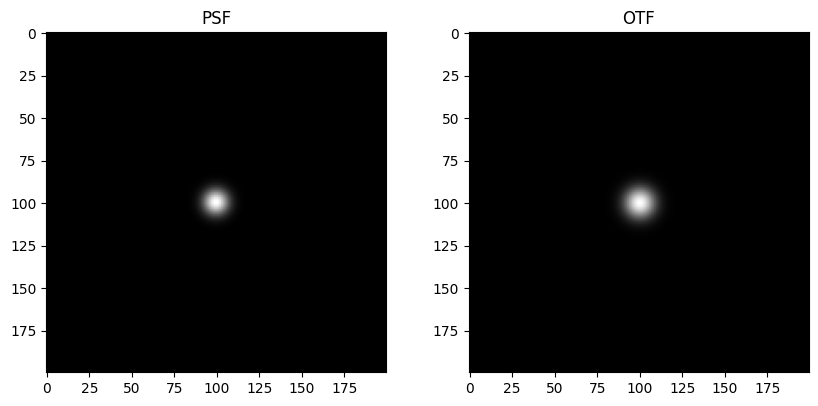

In [ ]:
import matplotlib.pyplot as plt

print("Displaying interactive visualization...")

PSF_np = PSF.detach().cpu().numpy()
OTF_np = OTF.detach().cpu().numpy()
print("PSF shape:", PSF_np.shape, "\nOTF shape:", OTF_np.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(bottom=0.2)

z = PSF_np.shape[0] // 2
im1 = axes[0].imshow(PSF_np[z], cmap="gray")
axes[0].set_title("PSF")

im2 = axes[1].imshow(OTF_np[z], cmap="gray")
axes[1].set_title("OTF")

plt.show()


# Visualise the Middle Slice of the Images

Displaying interactive visualization...
Image shape: (200, 200, 200) 
Ground truth shape: (200, 200, 200)
z slice:  100


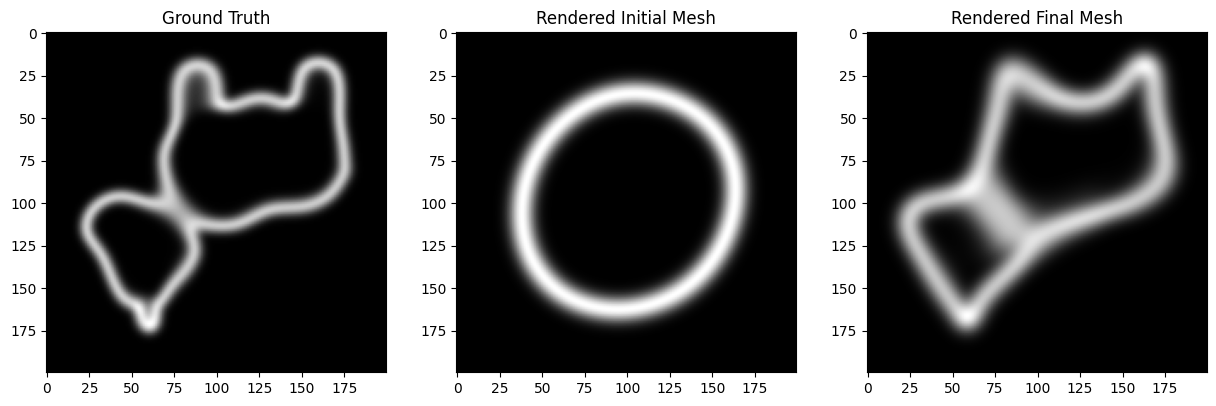

In [ ]:
import matplotlib.pyplot as plt

print("Displaying interactive visualization...")

image_sp_np = image_sp.detach().cpu().numpy()
micim_np = micim.detach().cpu().numpy()
image_sp_final = io.imread('Results_cow/Images/500.tif')
image_sp_final /= 255.0

print("Image shape:", image_sp_np.shape, "\nGround truth shape:", micim_np.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(bottom=0.2)

z = 100
print("z slice: ", z)
im1 = axes[0].imshow(micim_np[z], cmap="gray")
axes[0].set_title("Ground Truth")

im2 = axes[1].imshow(image_sp_np[z], cmap="gray")
axes[1].set_title("Rendered Initial Mesh")

im3 = axes[2].imshow(image_sp_final[z], cmap="gray")
axes[2].set_title("Rendered Final Mesh")

plt.show()



# Visualise DeltaMic on Fluorescenc Microscopy Images of Embryos

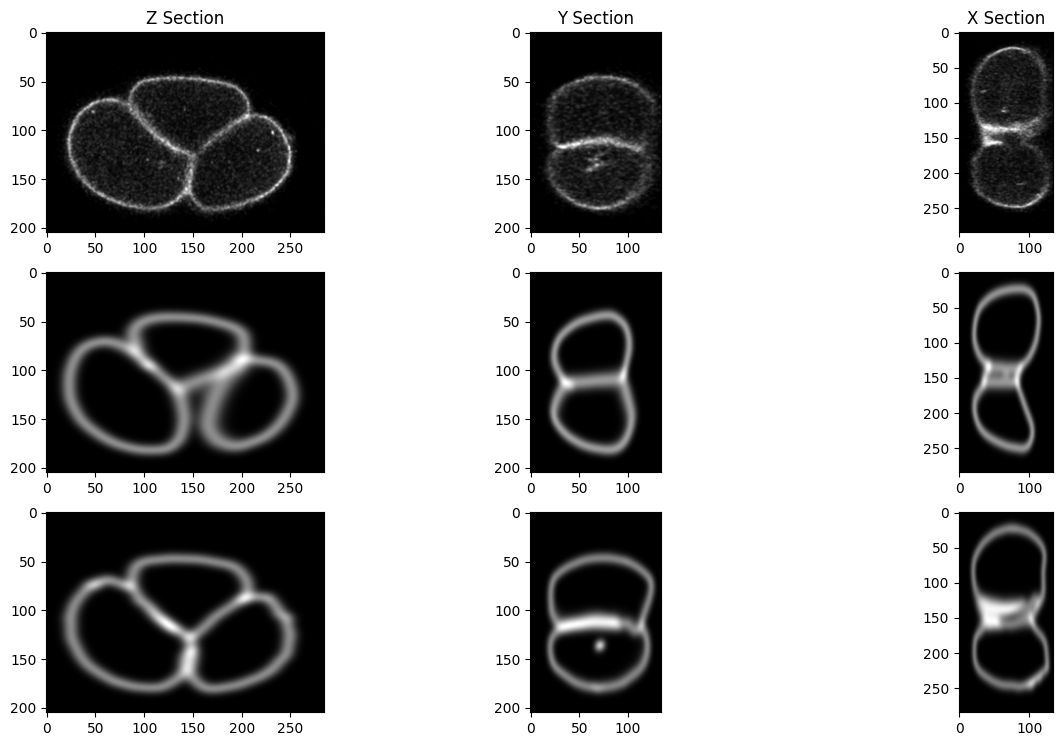

In [77]:
celegan_gt = io.imread("../data/image/Sample01_007.tif")
celegan_1k = io.imread("Results_Sample01_007/Images/100.tif")
celegan_10k = io.imread("Results_Sample01_007/Images/10000.tif")

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
plt.subplots_adjust(bottom=0.2)

x,y,z = (122, 122, 87)

# Raw Data
im1 = axes[0,0].imshow(celegan_gt[:, :, z], cmap="gray")
im1 = axes[0,1].imshow(celegan_gt[:, y, :], cmap="gray")
im1 = axes[0,2].imshow(celegan_gt[x], cmap="gray")
axes[0,0].set_title("Z Section")

# Reconstruction after 100 iterations
im2 = axes[1,0].imshow(celegan_1k[:, :, z], cmap="gray")
im2 = axes[1,1].imshow(celegan_1k[:, y, :], cmap="gray")
im2 = axes[1,2].imshow(celegan_1k[x], cmap="gray")
axes[0,1].set_title("Y Section")

# Reconstruction after 10000 iterations
im3 = axes[2,0].imshow(celegan_10k[:, :, z], cmap="gray")
im3 = axes[2,1].imshow(celegan_10k[:, y, :], cmap="gray")
im3 = axes[2,2].imshow(celegan_10k[x], cmap="gray")
axes[0,2].set_title("X Section")

plt.show()
